# Лабораторная работа 4

## Решение задачи экстраполяции населения страны

In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sym
import scipy as sp
import pandas as pd
import copy

import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

### Задача:

Решить задачу экстраполяции населения страны методами: 

1. Классическая полиномиальная интерполяция по Ньютону
2. Сплайн-интерполяция
3. Метод наименьших квадратов


### Исходные данные населения Беларуси:

In [2]:
data = mipt.read_excel('data/data.xlsx', usecols=(0,1), header=(0)).dropna()
data

,Year,Population
0,1950,7745000
1,1951,7765000
2,1952,7721000
3,1953,7600000
4,1954,7722000
...,...,...
70,2020,9410259
71,2021,9349645
72,2022,9255524
73,2023,9200617


In [3]:
def norm_vec(vec):
    return np.linalg.norm(vec, ord=np.inf)

def mat_norm(matrix):
    return np.linalg.norm(matrix, ord=np.inf)

threshold = 1e-10

def check_res(A, u, f, eps=threshold):
    norm = norm_vec(np.matmul(A, u) - f)
    return norm, abs(norm) < eps


## Полиномиальная интерполяция
### Формула Ньютона

$N_n(x) = \sum_{k=0}^{n} b_k \prod_{j=1}^{i+k-1} (x-x_j)$

In [4]:
def Newton(x_vals, f):
    if x_vals is None or f is None:
        return lambda x: -1
    
    degree = len(x_vals)
    
    b_coeffs = np.zeros((degree, degree))
    b_coeffs[0] = f
    
    for i in range(1, degree):
        prev_coeff = b_coeffs[i-1]
        b_coeffs[i][0:degree-i] = [(prev_coeff[m+1] - prev_coeff[m])/(x_vals[m+i] - x_vals[m]) for m in range(0, degree - i)]
        
    def N_deg(x):
        bpivot_coeff = b_coeffs.T[0]
        val = bpivot_coeff[degree-1]
        for m in reversed(range(0, degree-1)):
            val = bpivot_coeff[m] + (x - x_vals[m]) * val
            
        return val

    return N_deg

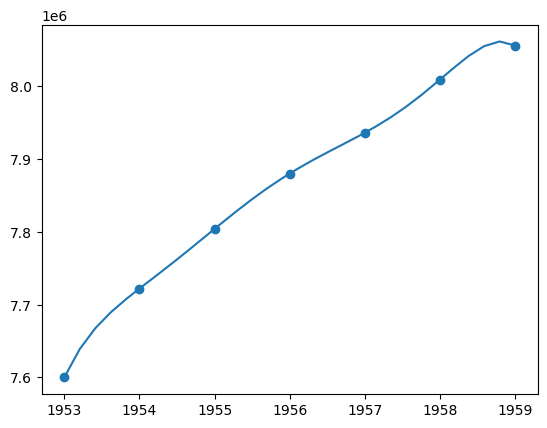

In [5]:
equ = Newton(np.copy(data['Year'][3:10]), np.copy(data['Population'][3:10]))
n_dots = 30
x = np.linspace(data['Year'][3], data['Year'][9], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][3:10], data['Population'][3:10])
plt.plot(x, y)
plt.show()


# Сплайн-интерполяция

In [6]:
def cyclic_thomas(n, f, lower, diag, upper):
    cmod = np.zeros(n)
    v = np.zeros(n)

    # Forward elimination
    cmod[1] = upper[1] / diag[1]
    v[1] = -lower[1] / diag[1]
    f[1] /= diag[1]

    for i in range(2, n - 1):
        m_factor = 1.0 / (diag[i] - lower[i] * cmod[i - 1])
        cmod[i] = upper[i] * m_factor
        v[i] = -lower[i] * v[i - 1] * m_factor
        f[i] = (f[i] - lower[i] * f[i - 1]) * m_factor

    # Handle last row
    m_last = 1.0 / (diag[n - 1] - lower[n - 1] * cmod[n - 2])
    cmod[n - 1] = upper[n - 1] * m_last
    v[n - 1] = (-upper[0] - lower[n - 1] * v[n - 2]) * m_last
    f[n - 1] = (f[n - 1] - lower[n - 1] * f[n - 2]) * m_last

    # Backward substitution
    for i in range(n - 2, 0, -1):
        v[i] -= cmod[i] * v[i + 1]
        f[i] -= cmod[i] * f[i + 1]

    # Solve for m[0]
    f[0] = (f[0] - lower[0] * f[n - 1] - upper[0] * f[1]) / (
        diag[0] + lower[0] * v[n - 1] + upper[0] * v[1]
    )

    f[1:] += f[0] * v

    return f


def cubic_spline_interpolation(h, b):
    n = len(h)  # Number of intervals
    
    # Construct the cyclic tridiagonal system
    diag = 2 * (h[:-1] + h[1:])  # Main diagonal
    lower = h[1:-1]              # Lower diagonal
    upper = h[1:-1]              # Upper diagonal
    f = 6 * (b[1:] - b[:-1])   # Right-hand side

    diag = np.hstack([1, diag, 1])  # Correct main diagonal size
    f = np.hstack([0, f, 0])    # Correct f size
    lower = np.hstack([0, h[:-1]])  # Pad lower diagonal
    upper = np.hstack([h[:-1], 0])  # Pad upper diagonal

    return cyclic_thomas(lower.shape[0], f, lower, diag, upper)
    

def cubic_polynomial(x, y):

    n = len(x) - 1  # Number of intervals
    h = np.diff(x)  # Spacing between consecutive x values
    b = np.diff(y) / h  # Slope between consecutive points
    m = cubic_spline_interpolation(h, b)
        
    splines = []

    def poly(arg):
        int_ind = np.searchsorted(x, arg)
        int_ind = np.clip(int_ind, 1, n)
        
        val = m[int_ind-1] * (x[int_ind] - arg)**3 / (6 * h[int_ind-1])                                 \
              + m[int_ind] * (arg - x[int_ind-1])**3 / (6 * h[int_ind-1])                               \
              + (y[int_ind-1] - m[int_ind-1] * h[int_ind-1]**2 / 6) * (x[int_ind] - arg) / h[int_ind-1]   \
              + (y[int_ind] - m[int_ind] * h[int_ind-1]**2 / 6) * (arg - x[int_ind-1]) / h[int_ind-1]
        return val

    return lambda arg: poly(arg)


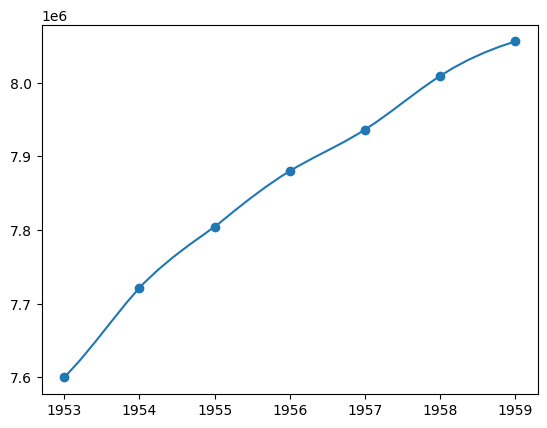

In [7]:
equ = cubic_polynomial(np.copy(data['Year'][3:10]), np.copy(data['Population'][3:10]))
x = np.linspace(data['Year'][3], data['Year'][9], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][3:10], data['Population'][3:10])
plt.plot(x, y)
plt.show()

## Метод наименьших квадратов

In [8]:
def leastSquares(x, y, phi):
    phi_im = np.array([[phi_i(x_m) for x_m in x] for phi_i in phi])

    f_i = np.matmul(phi_im, y)
    gram_ij = np.matmul(phi_im, phi_im.T)

    sols_j = np.linalg.solve(gram_ij, f_i)

    return lambda arg: np.array([np.sum([sol_i * phi_i(arg_m) for (sol_i, phi_i) in zip(sols_j, phi)]) for arg_m in np.atleast_1d(arg)])


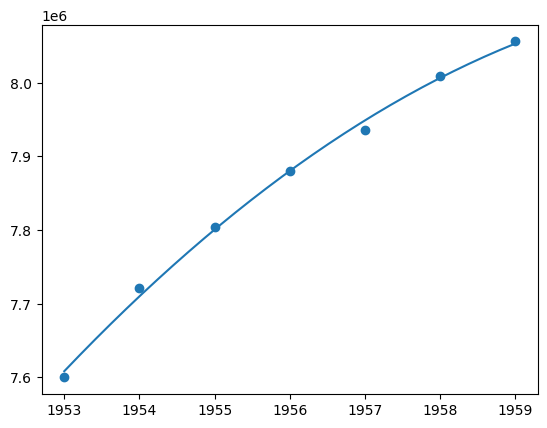

In [9]:
phi = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3
])

equ = leastSquares(np.copy(data['Year'][3:10]), np.copy(data['Population'][3:10]), phi)
x = np.linspace(data['Year'][3], data['Year'][9], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][3:10], data['Population'][3:10])
plt.plot(x, y)
plt.show()